In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import cv2 
import pickle
import glob

file_name = 'calibration.p'

with open(file_name, 'rb') as f:   
    mtx, dist = pickle.load(f)

## Useful Functions

In [4]:
# Draws viewing window onto copy of image
def draw_viewing_window(image,viewing_window):
    image_copy = np.copy(image)
    for line in viewing_window:
        for x1,y1,x2,y2 in line:
            cv2.line(image_copy,(x1,y1),(x2,y2),(0,255,0),5)
    return image_copy

# Makes the viewwing window which is used by draw_viewing_window()
def make_viewing_window(bottom_left,top_left,top_right,bottom_right):
    left_line = np.array([[bottom_left[0],bottom_left[1],top_left[0],top_left[1]]])
    top_line = np.array([[top_left[0],top_left[1],top_right[0],top_right[1]]])
    right_line = np.array([[top_right[0],top_right[1],bottom_right[0],bottom_right[1]]])
    bottom_line = np.array([[bottom_right[0],bottom_right[1],bottom_left[0],bottom_left[1]]])
    viewing_window = [left_line,top_line,right_line,bottom_line]

    return viewing_window

# Applies sobel algorithm with respect to x or y axis with thresholded gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh_min=0, thresh_max=255):
    
    
    # Convert to gray-scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take derivative
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_32F, 1, 0 ,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_32F, 0, 1,ksize=sobel_kernel)
    
    # Take absolute value of derivative    
    abs_sobel = np.absolute(sobel)
    
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Make copy of scaled_sobel with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary
    # binary_output = np.copy(img) # Remove this line
    return binary_output

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take derivatives in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Find magnitude of the gradient
    sum_of_squares = np.square(sobelx) + np.square(sobely)
    sobel_mag = np.power(sum_of_squares,0.5)
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Make a copy of sobel_mag with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary

    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Min and Max Threshold Angles
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the derivatives with respect to x and y
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Take absolute value of derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Calculate angle for direction of gradient in radians
    sobel_angle = np.arctan2(abs_sobely,abs_sobelx)
    # Make a copy of sobel_angle with all zeros
    sobel_binary = np.zeros_like(sobel_angle)
    # Apply thresholding
    sobel_binary[(sobel_angle >= thresh_min) & (sobel_angle <= thresh_max)] = 1
    binary_output = sobel_binary
    
    return binary_output

def region_of_interest(gray):
  m = np.copy(gray) + 1
  m[:, :225] = 0 
  m[:, 1100:] = 0 
  m[:,550:850] = 0
  return m 


# Takes in RGB image and applies color and gradient thresholding
def combined_threshold(image, kernel_size=3):
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = image_hls[:,:,2]
    S_thresholded = np.zeros_like(S)
    thresh_S = (140, 255)
    S_thresholded[(S >= thresh_S[0]) & (S <= thresh_S[1])] = 1
    
    L = image_hls[:,:,1]
    L_thresholded = np.zeros_like(L)
    thresh_L = (40,255)
    L_thresholded[(L >=thresh_L[0]) & (L <= thresh_L[1])] = 1
    thresh_L_agr = 205
    L_thresholded2 = np.zeros_like(L)
    L_thresholded2[L>=thresh_L_agr] = 1
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh_min=40,
                             thresh_max=255)
    # I did not use grady in the final output
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=kernel_size, thresh_min=20,
                             thresh_max=100)
    mag_binary = sobel_mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(40,255))
    dir_binary = dir_threshold(image,sobel_kernel=kernel_size,thresh=(0.7,1.3))

    combined = np.zeros_like(dir_binary)
    """
    combined[(((gradx == 1)) | \
             ((mag_binary == 1) & (dir_binary == 1)) \
              | (S_thresholded == 1)) ] = 1
    """
    
    combined[((mag_binary == 1) & (dir_binary == 1) & (gradx == 1)) | \
             (((S_thresholded == 1) & (L_thresholded == 1)) | (L_thresholded2 == 1))] = 1
    combined = np.logical_and(combined,region_of_interest(combined)).astype(np.uint8)
    
    return combined


def apply_birdseye_and_thresholding(image,source_points,dest_points):
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])
    birds_eye_image = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    combined = combined_threshold(birds_eye_image,kernel_size=11)
    
    
    return combined
    

## Undistorting the Image

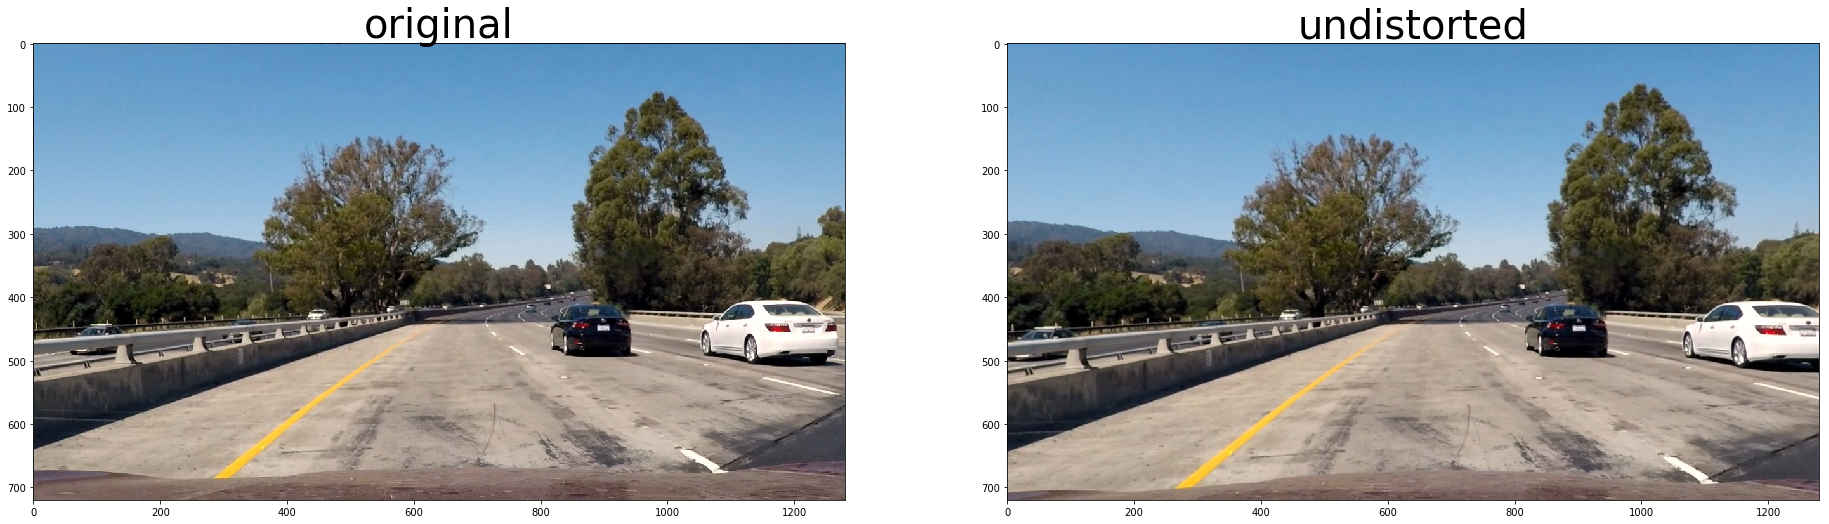

In [5]:
image = mpimg.imread('test_images/test1.jpg')
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

f, axs = plt.subplots(1,2, figsize=(32,12))
axs[0].imshow(image)
axs[0].set_title('original',fontsize=40)
axs[1].imshow(image_undistorted)
axs[1].set_title('undistorted',fontsize=40)

## Converting to BirdsEye View

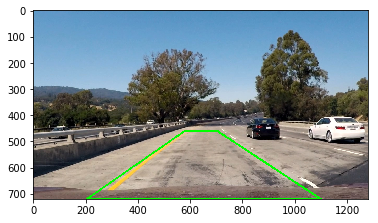

In [6]:
# Defining my source points
src_bottom_left = [580,460]
src_top_left = [205,720]
src_top_right = [1100,720]
src_bottom_right = [703,460]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])

src_viewing_window = make_viewing_window(src_bottom_left,src_top_left,src_top_right,src_bottom_right)
image_copy = draw_viewing_window(image,src_viewing_window)
plt.imshow(image_copy)

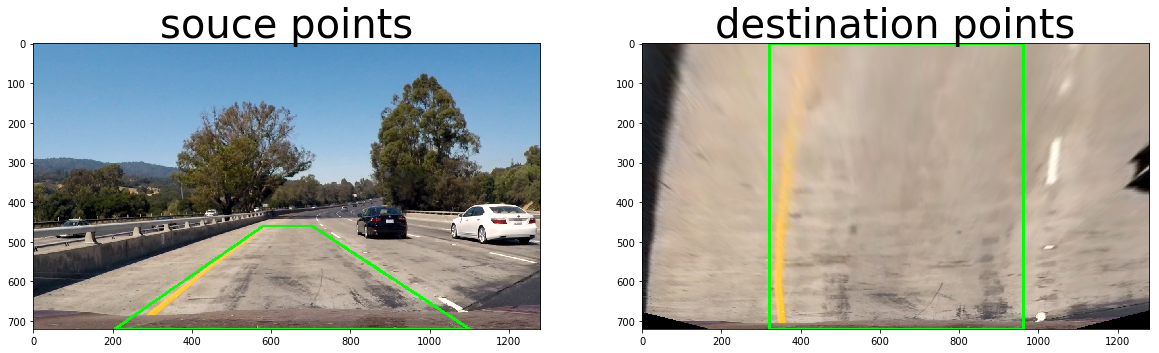

In [7]:
# Defining my destination points
dest_bottom_left = [320,0]
dest_top_left = [320,720]
dest_top_right = [960,720]
dest_bottom_right = [960,0]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])

image_copy = np.copy(image)
M = cv2.getPerspectiveTransform(source_points,dest_points)
Minv = cv2.getPerspectiveTransform(dest_points,source_points)
img_size = (image.shape[1],image.shape[0])
birds_eye_image = cv2.warpPerspective(image_copy, M, img_size,
                                      flags=cv2.INTER_LINEAR)
dest_viewing_window = make_viewing_window(dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right)

src_image_copy = draw_viewing_window(image,src_viewing_window)
dest_image_copy = draw_viewing_window(birds_eye_image,dest_viewing_window)


f,axs = plt.subplots(1,2,figsize=(20,20))
axs = axs.ravel()
axs[0].imshow(src_image_copy)
axs[0].set_title('souce points',fontsize=40)
axs[1].imshow(dest_image_copy)
axs[1].set_title('destination points',fontsize=40)

## Apply birdseye view and color and gradient thresholding

i:  0
i:  1
i:  2
i:  3
i:  4
i:  5


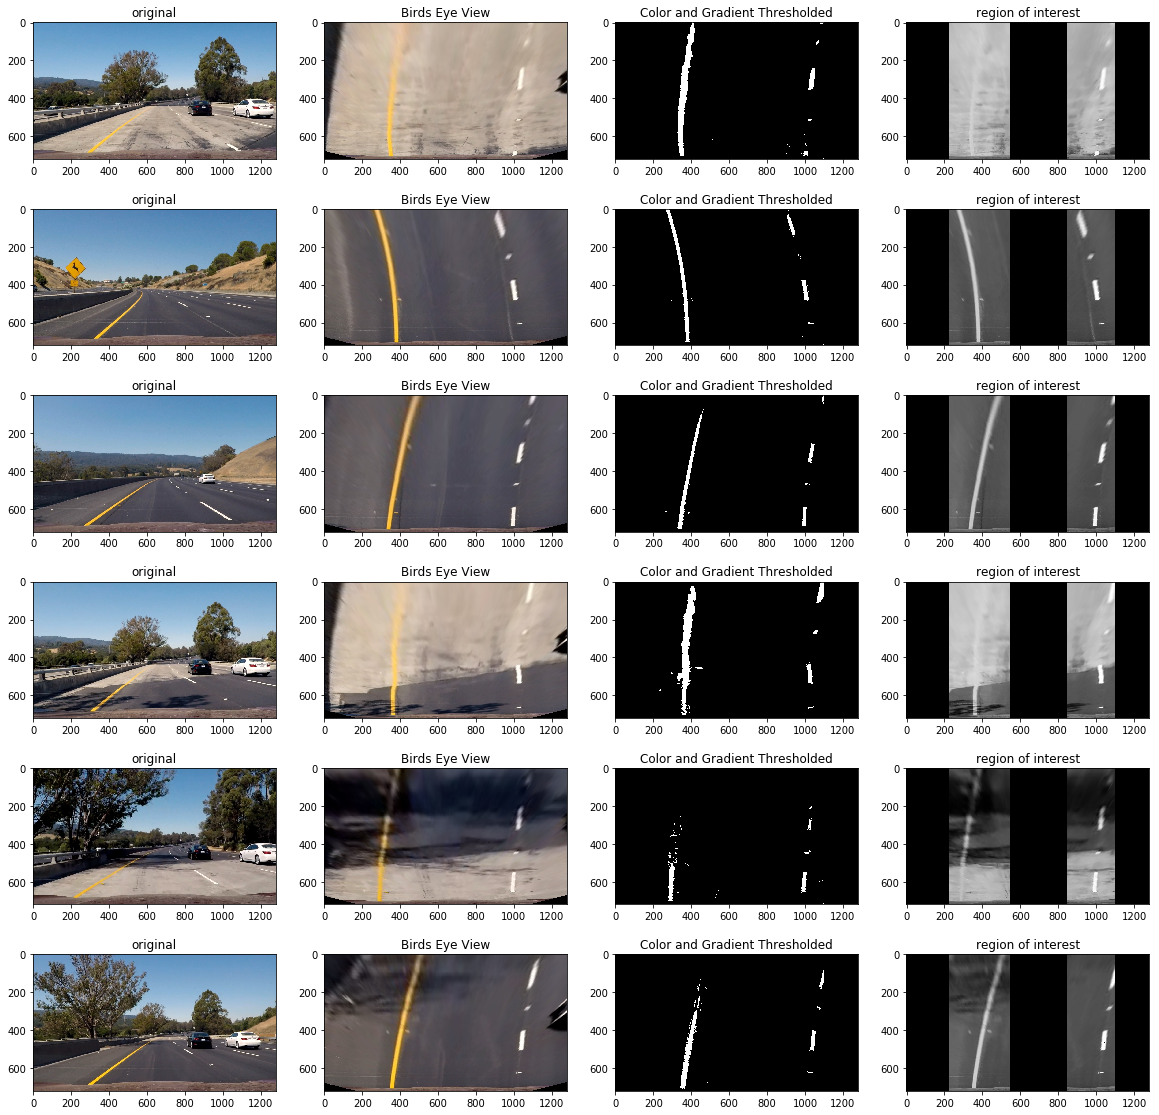

In [30]:
count = 0
f,axs = plt.subplots(6,4,figsize=(20,20))
axs = axs.ravel()
for i in range(0,6):
    print('i: ',i)
    img = 'test_images/test' + str(i+1) + '.jpg'
    image = mpimg.imread(img)
    #image = mpimg.imread('test_images/test3.jpg')

    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])
    birds_eye_image = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    combined = combined_threshold(birds_eye_image,kernel_size=11)
    
    gray = cv2.cvtColor(birds_eye_image, cv2.COLOR_RGB2GRAY)
    gray = region_of_interest(gray)
    
    #combined = apply_birdseye_and_thresholding(image,source_points,dest_points)
    axs[i*4].imshow(image)
    axs[i*4].set_title('original')
    axs[i*4+1].imshow(birds_eye_image)
    axs[i*4+1].set_title('Birds Eye View')
    axs[i*4+2].imshow(combined,cmap='gray')
    axs[i*4+2].set_title('Color and Gradient Thresholded')
    axs[i*4+3].imshow(gray,cmap='gray')
    axs[i*4+3].set_title('region of interest')
    
plt.show()


## Draw Best-Fit Curve

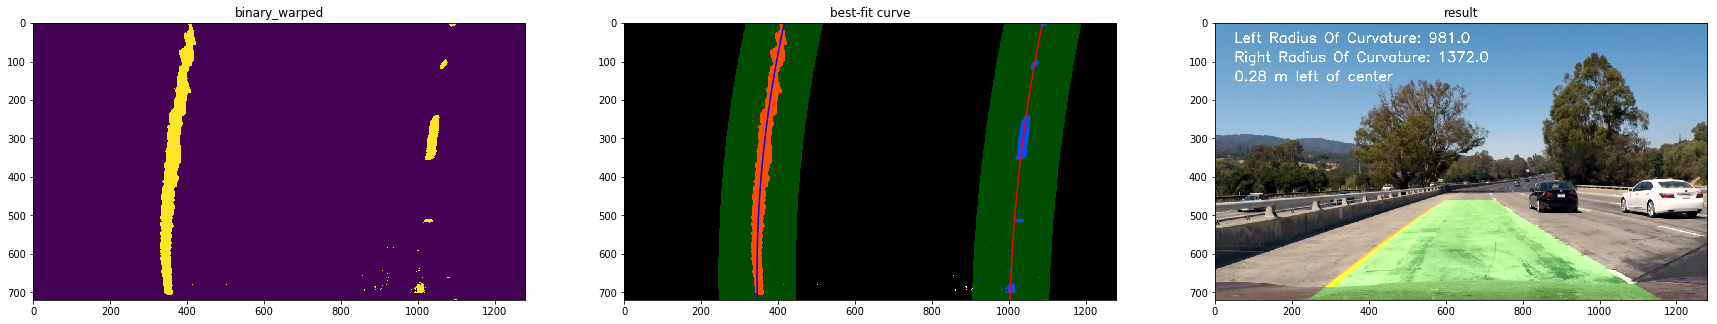

In [25]:
src_bottom_left = [580,460]
src_top_left = [205,720]
src_top_right = [1100,720]
src_bottom_right = [703,460]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])

dest_bottom_left = [320,0]
dest_top_left = [320,720]
dest_top_right = [960,720]
dest_bottom_right = [960,0]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])

img = 'test_images/test1.jpg'
image = mpimg.imread(img) 
binary_warped = apply_birdseye_and_thresholding(image,source_points,dest_points)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#plt.plot(histogram)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
#nwindows = 9
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
#margin = 100
margin = 100
# Set minimum number of pixels found to recenter window
#minpix = 50
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
left_fit = None
right_fit = None
if ((left_fit == None) and (right_fit == None)):
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #f, axs = plt.subplots(1,2)
    #axs = axs.ravel()
    #axs[0].imshow(binary_warped)

    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='red')
    #plt.plot(right_fitx, ploty, color='blue')

#axs[1].imshow(out_img)
"""
axs[1].imshow(binary_warped)
axs[1].plot(left_fitx, ploty, color='red')
axs[1].plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)
"""

plt.show()

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result2 = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
"""
plt.imshow(result2)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
"""

# Calculating radius of curvature at bottom of picture in pixels
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
#print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

warped = binary_warped
 

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

height = image.shape[0]
width = image.shape[1]
vehicle_center = width/2
left_lane_position = (left_fit_cr[0] * (height**2)) + (left_fit_cr[1] * height) + left_fit_cr[2]
right_lane_position = (right_fit_cr[0] * (height**2)) + (right_fit_cr[1] * height) + right_fit_cr[2]
actual_center = left_lane_position + (right_lane_position - left_lane_position) / 2
vehicle_position = (actual_center - vehicle_center) * xm_per_pix
vehicle_position = (np.round(vehicle_position/8,2))



font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, "Left Radius Of Curvature: " + str(round(left_curverad,0)), (50, 50), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(result, "Right Radius Of Curvature: " + str(round(right_curverad,0)), (50, 100), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
if (vehicle_position < 0):
    vehicle_position_str = str(np.absolute(vehicle_position)) + " m left of center"
elif (vehicle_position > 0):
    vehicle_position_str = str(np.absolute(vehicle_position)) + " m right of center"
else:
    vehicle_position_str =  "on center"
cv2.putText(result, vehicle_position_str, (50,150), font, 1.2, (255,255,255), 2, cv2.LINE_AA)

f,axs = plt.subplots(1,3,figsize=(30,15))
axs = axs.ravel()
axs[0].imshow(binary_warped)
axs[0].set_title('binary_warped')
axs[1].imshow(result2)
axs[1].plot(left_fitx, ploty, color='blue')
axs[1].plot(right_fitx, ploty, color='red')
axs[1].set_title('best-fit curve')
axs[2].imshow(result)
axs[2].set_title('result')



## Put everything into one function

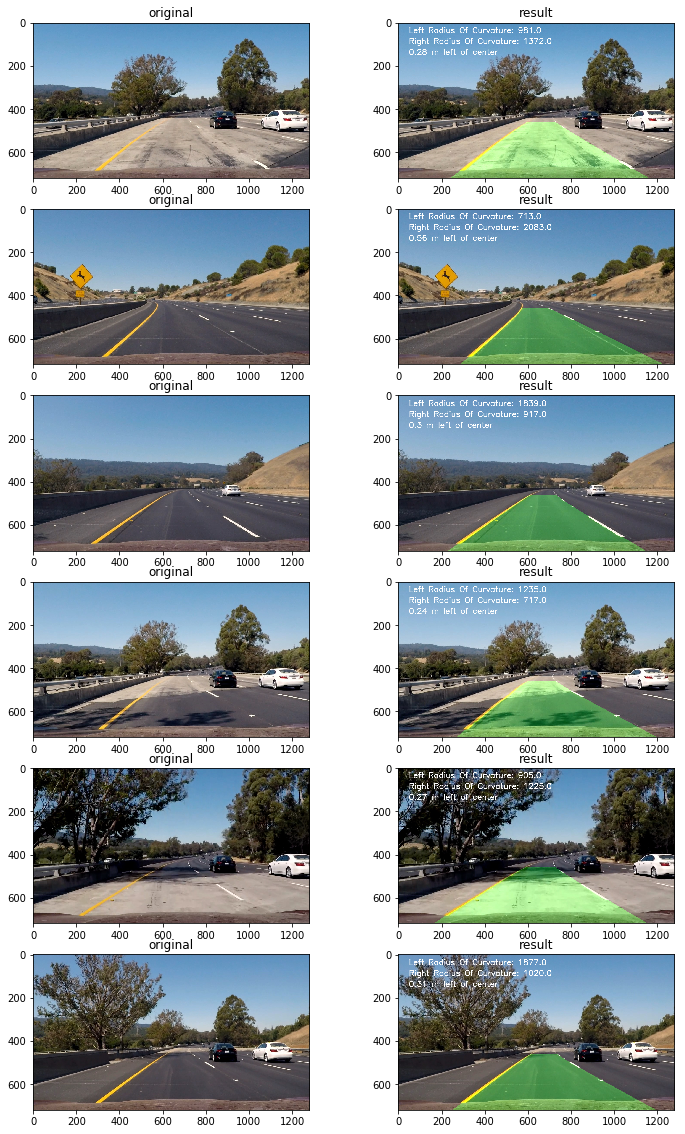

In [29]:
src_bottom_left = [580,460]
src_top_left = [205,720]
src_top_right = [1100,720]
src_bottom_right = [703,460]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])

dest_bottom_left = [320,0]
dest_top_left = [320,720]
dest_top_right = [960,720]
dest_bottom_right = [960,0]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])


def process_image(image,source_points,dest_points):
    
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)

    binary_warped = apply_birdseye_and_thresholding(image,source_points,dest_points)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print('leftx_base: ',leftx_base)
    #print('rightx_base: ',rightx_base)
    # Choose the number of sliding windows
    #nwindows = 9
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result2 = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


    # Calculating radius of curvature at bottom of picture in pixels
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    #print('length of ploty: ',len(ploty))
    #print('length of leftx: ',len(leftx))
    #print('length of rightx: ',len(rightx))
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    warped = binary_warped


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    height = image.shape[0]
    width = image.shape[1]
    vehicle_center = width/2
    left_lane_position = (left_fit_cr[0] * (height**2)) + (left_fit_cr[1] * height) + left_fit_cr[2]
    right_lane_position = (right_fit_cr[0] * (height**2)) + (right_fit_cr[1] * height) + right_fit_cr[2]
    actual_center = left_lane_position + (right_lane_position - left_lane_position) / 2
    vehicle_position = (actual_center - vehicle_center) * xm_per_pix
    vehicle_position = round((vehicle_position/8),2)



    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, "Left Radius Of Curvature: " + str(round(left_curverad,0)), (50, 50), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, "Right Radius Of Curvature: " + str(round(right_curverad,0)), (50, 100), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    if (vehicle_position < 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " m left of center"
    elif (vehicle_position > 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " m right of center"
    else:
        vehicle_position_str =  "on center"
    cv2.putText(result, vehicle_position_str, (50,150), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    
    return result

img = 'test_images/test5.jpg'
image = mpimg.imread(img) 
result = process_image(image,source_points,dest_points)

f,axs = plt.subplots(6,2,figsize=(12,20))
axs = axs.ravel()
for i in range(0,6):
    img = 'test_images/test' + str(i+1) + '.jpg'
    image = mpimg.imread(img)
    result = process_image(image,source_points,dest_points)
    
    axs[i*2].imshow(image)
    axs[i*2].set_title('original')
    axs[i*2+1].imshow(result)
    axs[i*2+1].set_title('result')
    





